## Customizable radiometric terrain corrections of Sentinel-1 products

The Planetary Computer includes both [Sentinel-1 Level-1 Ground Range Detected (GRD)](https://planetarycomputer-staging.microsoft.com/dataset/sentinel-1-grd) and [Sentinel-1 Radiometrically Terrain Corrected (RTC)](https://planetarycomputer-staging.microsoft.com/dataset/sentinel-1-rtc) collections. This tutorial explains the some background on Synthetic Aperture Radar (SAR), geometric and radiometric terrain correction, and introduces [sarsen](https://github.com/bopen/sarsen), an open-source library for working with SAR data. `sarsen` enables geometric and radiometric corrections using any digital elevation model (DEM) supported by GDAL / Proj.

### Background

The typical side-looking [Synthetic Aperture Radar (SAR)](https://earthdata.nasa.gov/learn/backgrounders/what-is-sar) system acquires data with uniform sampling in azimuth and slant range, where the azimuth and range represents the time when a given target is acquired and the absolute sensor-to-target distance, respectively.
Because of this, the near range appears compressed with respect to the far range. Furthermore, any deviation of the target elevation from a smooth geoid results in additional local geometric and radiometric distortions known as foreshortening, layover and shadow.

- Radar foreshortening: Terrain surfaces sloping towards the radar appear shortened relative to those sloping away from the radar.
- Radar layover: It's an extreme case of foreshortening occurring when the terrain slope is greater than the angle of the incident signal.  
- Radar shadows: They occur when ground points at the same azimuth but different slant ranges are aligned in the direction of the line-of-sight. This is usually due to a back slope with an angle steeper than the viewing angle. When this happens, the radar signal never reaches the farthest points, and thus there is no measurement, meaning that this lack of information is unrecoverable.

### Geometric Terrain Correction

The [Sentinel-1 GRD](https://planetarycomputer-staging.microsoft.com/dataset/sentinel-1-grd) product already provides a geometric correction that removes the compression effect on the near-range. Geometric Terrain Correction *also* corrects for displacements due to target elevation. When applying geometric terrain correction, the resolution and accuracy of the input Digital Elevation Model (DEM). The Planetary Computer has a number of [DEMs](https://planetarycomputer.microsoft.com/catalog?tags=DEM) to choose from.

### Radiometric Terrain Correction

Terrain variations affect both the position of a given point on the Earth's surface *and* the brightness of the radar return. The `sarsen` radiometric terrain correction compensates for the backscatter modulation generated by the topography of the scene. This produces a more uniform backscatter image, emphasizing the radiometric differences of the terrain.

The accuracy of Radiometric Terrain Corrected (RTC) products is also strongly affected by the resolution of the input DEM.

This tutorial shows how to perform (i) geometric and (ii) radiometric terrain corrections on the Sentinel-1 GRD product using `sarsen`. We use a 10-meter resolution DEM, the same resolution of the DEM used to generate the [Sentinel-1 RTC product](https://planetarycomputer-staging.microsoft.com/dataset/sentinel-1-rtc) available on the Planetary Computer. The comparison at the end of this notebook demonstrates that the RTC computed by `sarsen` is consistent with the RTC from the Planetary Computer.

As an example, we use data convering the South-of-Redmond region (Seattle, US).

Steps:

- Download the Sentinel-1 GRD
- Download the 10-meter DEM
- Compute the GTC using `sarsen`
- Compute the RTC using `sarsen`
- Compare the GTC to the RTC
- Compare the RTC computed using `sarsen` to the RTC already available on the Planetery Computer 

**Note**: Download/retrieval steps are slower on local machines compared to the Planetary Computer. In future versions, it will be possible to access data via [fsspec](https://filesystem-spec.readthedocs.io/en/latest/) without having to download data locally.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 7)

In [2]:
import os
import tempfile

import rioxarray

from sarsen import apps

import adlfs
import planetary_computer
import pystac_client
import stackstac

### Processing definitions

In [3]:
# create a temporary directory where to store downloaded data
tmp_dir = tempfile.gettempdir()

# DEM path
dem_path = os.path.join(tmp_dir, "South-of-Redmond-10m.tif")

# path to Sentinel-1 input product in the Planetary Computer
product_folder = "GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048"  # noqa: E501

# band to be processed
measurement_group = "IW/VV"

tmp_dir

'/tmp'

#### Area of interest definition: South-of-Redmond (Seattle, US)

In [4]:
lon, lat = [-121.95, 47.04]
buffer = 0.2
bbox = [lon - buffer, lat - buffer, lon + buffer, lat + buffer]

#### DEMs discovery

Here we use the [USGS 3dep-seamles DEM](https://planetarycomputer.microsoft.com/dataset/3dep-seamless) with a 10-meter ground sample distance (GDS). Note that **any DEM supported by GDAL/Proj can be used**.

Using `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.  
As multiple DEMs acquired at different times are available in this area, we select the DEMs with 10-meter GDS and perform the average of the remaining DEMs along the time dimension.

In [5]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1"
)
search = catalog.search(
    collections="3dep-seamless", bbox=bbox, query={"gsd": {"eq": 10}}
)
items = search.get_all_items()

Here we load the data into an xarray `DataArray` using stackstac.

In [6]:
dem_raster_all = stackstac.stack(planetary_computer.sign(items), bounds=bbox).squeeze()
dem_raster_all

<xarray.DataArray 'stackstac-d90c33d750479ce84c6f5eda1b1f3eec' (time: 4,
                                                                y: 4321, x: 4321)>
dask.array<getitem, shape=(4, 4321, 4321), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time             (time) datetime64[ns] 2018-02-02 2018-02-08 ... 2020-01-07
    id               (time) <U10 'n48w122-13' 'n47w122-13' ... 'n48w123-13'
    band             <U4 'data'
  * x                (x) float64 -122.2 -122.1 -122.1 ... -121.8 -121.8 -121.8
  * y                (y) float64 47.24 47.24 47.24 47.24 ... 46.84 46.84 46.84
    proj:shape       object {10812}
    ...               ...
    threedep:region  <U7 'n40w130'
    proj:epsg        int64 5498
    gsd              int64 10
    end_datetime     (time) <U20 '2016-12-31T00:00:00Z' ... '2019-04-25T00:00...
    description      <U1849 'This tile of the 3D Elevation Program (3DEP) sea...
    epsg             int64 5498
Attributes:
    spec:        RasterSpec(epsg=5498, bounds=(-122.15000053746, 46.839907613...
    crs:         epsg:5498
    transform:   | 0.00, 0.00,-122.15|\n| 0.00,-0.00, 47.24|\n| 0.00, 0.00, 1...
    resolution:  9.2592593e-05

#### DEMs average along the time dimension

In [7]:
dem_raster_geo = dem_raster_all.compute()
if "time" in dem_raster_geo.dims:
    dem_raster_geo = dem_raster_geo.mean("time")
_ = dem_raster_geo.rio.set_crs(dem_raster_all.rio.crs)

#### Convert the DEM in UTM coordinates

In order to facilitate the comparison between the RTC computed by sarsen with the RTC available on the Planetery Computer, here we convert the DEM in UTM.

In [8]:
# find the UTM zone and project in UTM
t_srs = dem_raster_geo.rio.estimate_utm_crs()
dem_raster = dem_raster_geo.rio.reproject(t_srs, resolution=(10, 10))

# crop DEM to our area of interest and save it
dem_corners = dict(x=slice(565000, 594000), y=slice(5220000, 5190000))


dem_raster = dem_raster.sel(**dem_corners)
dem_raster.rio.to_raster(dem_path)
dem_raster

<xarray.DataArray 'stackstac-d90c33d750479ce84c6f5eda1b1f3eec' (y: 3000, x: 2900)>
array([[ 196.68109131,  196.14202881,  194.11082458, ...,  820.71972656,
         820.05755615,  819.68597412],
       [ 196.68109131,  196.14202881,  195.13980103, ...,  817.84838867,
         814.0760498 ,  814.61773682],
       [ 197.03511047,  195.65205383,  195.13980103, ...,  812.12884521,
         810.13116455,  809.48669434],
       ...,
       [ 602.28057861,  607.78918457,  609.63909912, ..., 4130.93261719,
        4135.22167969, 4137.34033203],
       [ 597.96710205,  602.36712646,  603.93676758, ..., 4133.00195312,
        4137.37695312, 4139.43896484],
       [ 594.58496094,  599.09234619,  600.71466064, ..., 4135.22558594,
        4139.52978516, 4141.82373047]])
Coordinates:
  * x                (x) float64 5.65e+05 5.65e+05 ... 5.94e+05 5.94e+05
  * y                (y) float64 5.22e+06 5.22e+06 ... 5.19e+06 5.19e+06
    proj:shape       object {10812}
    band             <U4 'data'
    threedep:region  <U7 'n40w130'
    epsg             int64 5498
    proj:epsg        int64 5498
    description      <U1849 'This tile of the 3D Elevation Program (3DEP) sea...
    gsd              int64 10
    spatial_ref      int64 0
Attributes:
    _FillValue:  1.7976931348623157e+308

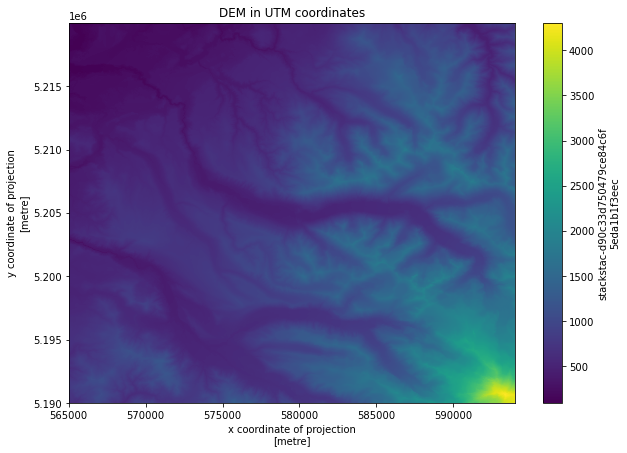

In [9]:
dem_raster.plot()
plt.title("DEM in UTM coordinates");

### Define GRD parameters

In [10]:
grd_account_name = "sentinel1euwest"
grd_storage_container = "s1-grd"
grd_product_folder = f"{grd_storage_container}/{product_folder}"
grd_local_path = os.path.join(tmp_dir, product_folder)

### Retrieve Sentinel-1 GRD

We'll use the Planetary Compueter's [SAS API](https://planetarycomputer.microsoft.com/docs/concepts/sas/) to get a read-only token for the Sentinel-1 GRD container.

In [11]:
grd_token = planetary_computer.sas.get_token(
    grd_account_name, grd_storage_container
).token
grd_fs = adlfs.AzureBlobFileSystem(grd_account_name, credential=grd_token)
grd_fs.ls(f"{grd_product_folder}/manifest.safe")

['s1-grd/GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048/manifest.safe']

In [12]:
grd_fs.get(grd_product_folder, grd_local_path, recursive=True)
!ls -d {grd_local_path}

/tmp/GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048


### Processing

#### GTC

Here we compute the geometric terrain correction.

Input parameters:
- `product_urlpath`: product path
- `measurement_group`: band to be processed in the form {swath}/{polarization} (see [xarray-sentinel](https://pypi.org/project/xarray-sentinel/) for more details)
- `dem_urlpath`: path to the input DEM. sarsen supports all DEMs supported by GDAL/Proj for ECEF-translation. 
- `interp_method`: interpolation method, sarsen supports all interpolation methods supported by [xarray.Dataset.interp](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.interp.html)
- `chunks`: dask chunks
- `output_urlpath`: output path

The output is the input SAR image resampled on DEM coordinates. 

In [13]:
gtc = apps.terrain_correction(
    product_urlpath=grd_local_path,
    measurement_group=measurement_group,
    dem_urlpath=dem_path,
    output_urlpath=os.path.join(
        tmp_dir, os.path.basename(product_folder) + ".10m.GTC.tif"
    ),
)

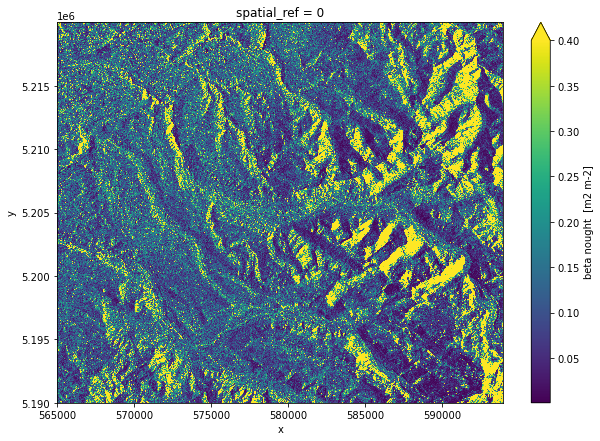

In [14]:
gtc.plot(vmax=0.4);

#### RTC

`sarsen` implements the radiometric terrain-correction [Gamma Flattening](https://ieeexplore.ieee.org/document/5752845) algorithm.

#### Input parameters
- `correct_radiometry`: default `None`. If `correct_radiometry=None`the radiometric terrain correction is not applied. `correct_radiometry=gamma_bilinear` applies the gamma flattening classic algorithm using bilinear interpolation to compute the weights. `correct_radiometry=gamma_nearest` applies the gamma flattening using nearest neighbours instead of bilinear interpolation. 'gamma_nearest' significantly reduces the processing time.
- `grouping_area_factor`: scaling factor for the size of the image pixel where the areas are summed. By default, the `grouping_area_factor` is `(1, 1)`, which corresponds to Sentinel-1 input product pixel size. The `grouping_area_factor` shall be increased if the DEM resolution is lower than the Sentinel-1 input product resolution to avoid gaps and distortions the normalization factor. It can be also used to to speed up the computation or  the DEM resolution is lower than the Sentinel-1 input product resolution.  


**Note**: The `grouping_area_factor` can be increased (i) to speed up the processing or (ii) when the input DEM resolution is low. The Gamma Flattening usually works properly if the pixel size of the input DEM is much smaller than the pixel size of the input Sentinel-1 product. Otherwise, the output may have radiometric distortions. This problem can be avoided by increasing the `grouping_area_factor`. Be aware that `grouping_area_factor` too high may degrade the final result.

**Note:** As the RTC genaration step loads data into the memory, it may take serveral minutes (about 10 minutes on the Planetary Computer). The performances will be improved in the next releases of `sarsen`.

In [15]:
rtc = apps.terrain_correction(
    grd_local_path,
    measurement_group=measurement_group,
    dem_urlpath=dem_path,
    correct_radiometry="gamma_bilinear",
    output_urlpath=os.path.join(
        tmp_dir, os.path.basename(product_folder) + ".10m.RTC.tif"
    ),
    grouping_area_factor=(3, 3),
)

### Comparison between GTC and RTC

Let's visualize the geometrically and radiometrically terrain corrected data:

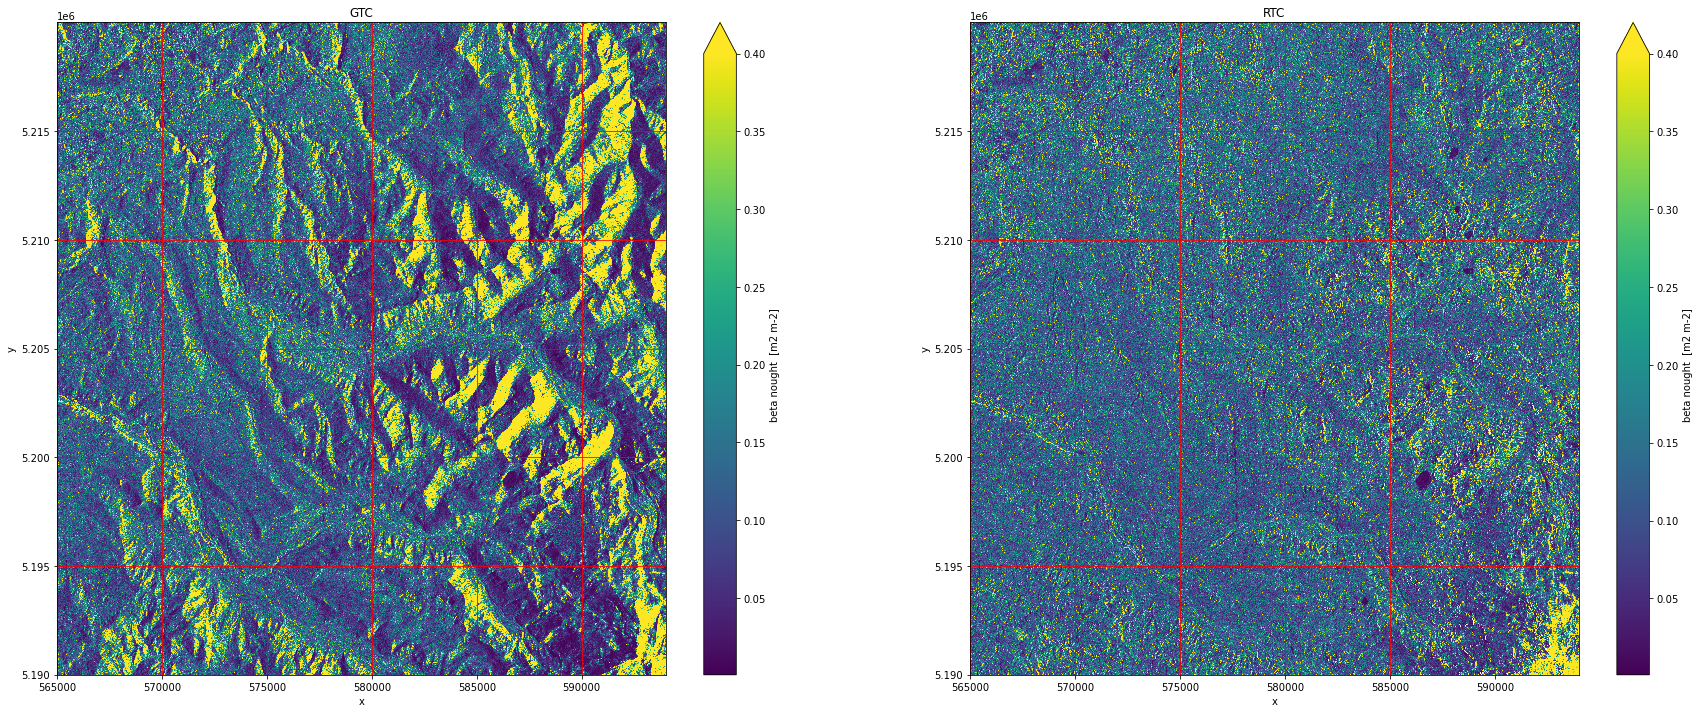

In [16]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12))

gtc.plot(ax=axes[0], vmax=0.4)
axes[0].grid(c="red")
axes[0].set(title="GTC")

rtc.plot(ax=axes[1], vmax=0.4)
axes[1].grid(c="red")
axes[1].set(title="RTC");

### Comparison between Planetary Computer RTC and sarsen RTC

Finally, let's compare the pre-computed Sentinel-1 RTC with the customizable RTC from sarsen. We'll use the Planetary Computer's STAC API to find the matching scene from the Sentinel-1 RTC collection.

Note: accessing data from the `sentinel-1-rtc` collection requies an account on the Planetary Computer. See [When an account is needed](https://planetarycomputer-staging.microsoft.com/docs/concepts/sas/#when-an-account-is-needed) for more.

In [17]:
search = catalog.search(
    collections=["sentinel-1-rtc"], datetime="2021-12-17", bbox=bbox
)
items = search.get_all_items()
print(f"Found {len(items)} items")
item = planetary_computer.sign(items[0])
item

Found 1 items


<Item id=S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_rtc>

We'll load up the pre-computed RTC data:

In [18]:
rtc_pc = rioxarray.open_rasterio(item.assets["vv"].href).drop("band").sel(dem_corners)
rtc_pc

<xarray.DataArray (band: 1, y: 3000, x: 2900)>
[8700000 values with dtype=float32]
Coordinates:
  * x            (x) float64 5.65e+05 5.65e+05 5.65e+05 ... 5.94e+05 5.94e+05
  * y            (y) float64 5.22e+06 5.22e+06 5.22e+06 ... 5.19e+06 5.19e+06
    spatial_ref  int64 0
Dimensions without coordinates: band
Attributes:
    Matrix_Element:   _1_1
    Polarization:     VV
    SARPixelContent:  intensity
    Scale:            linear
    _FillValue:       -32768.0
    scale_factor:     1.0
    add_offset:       0.0
    long_name:        Sentinel-1 Calibrated and Terrain Corrected VV

And plot the results, with the pre-computed RTC on the left and sarsen's RTC on the right.

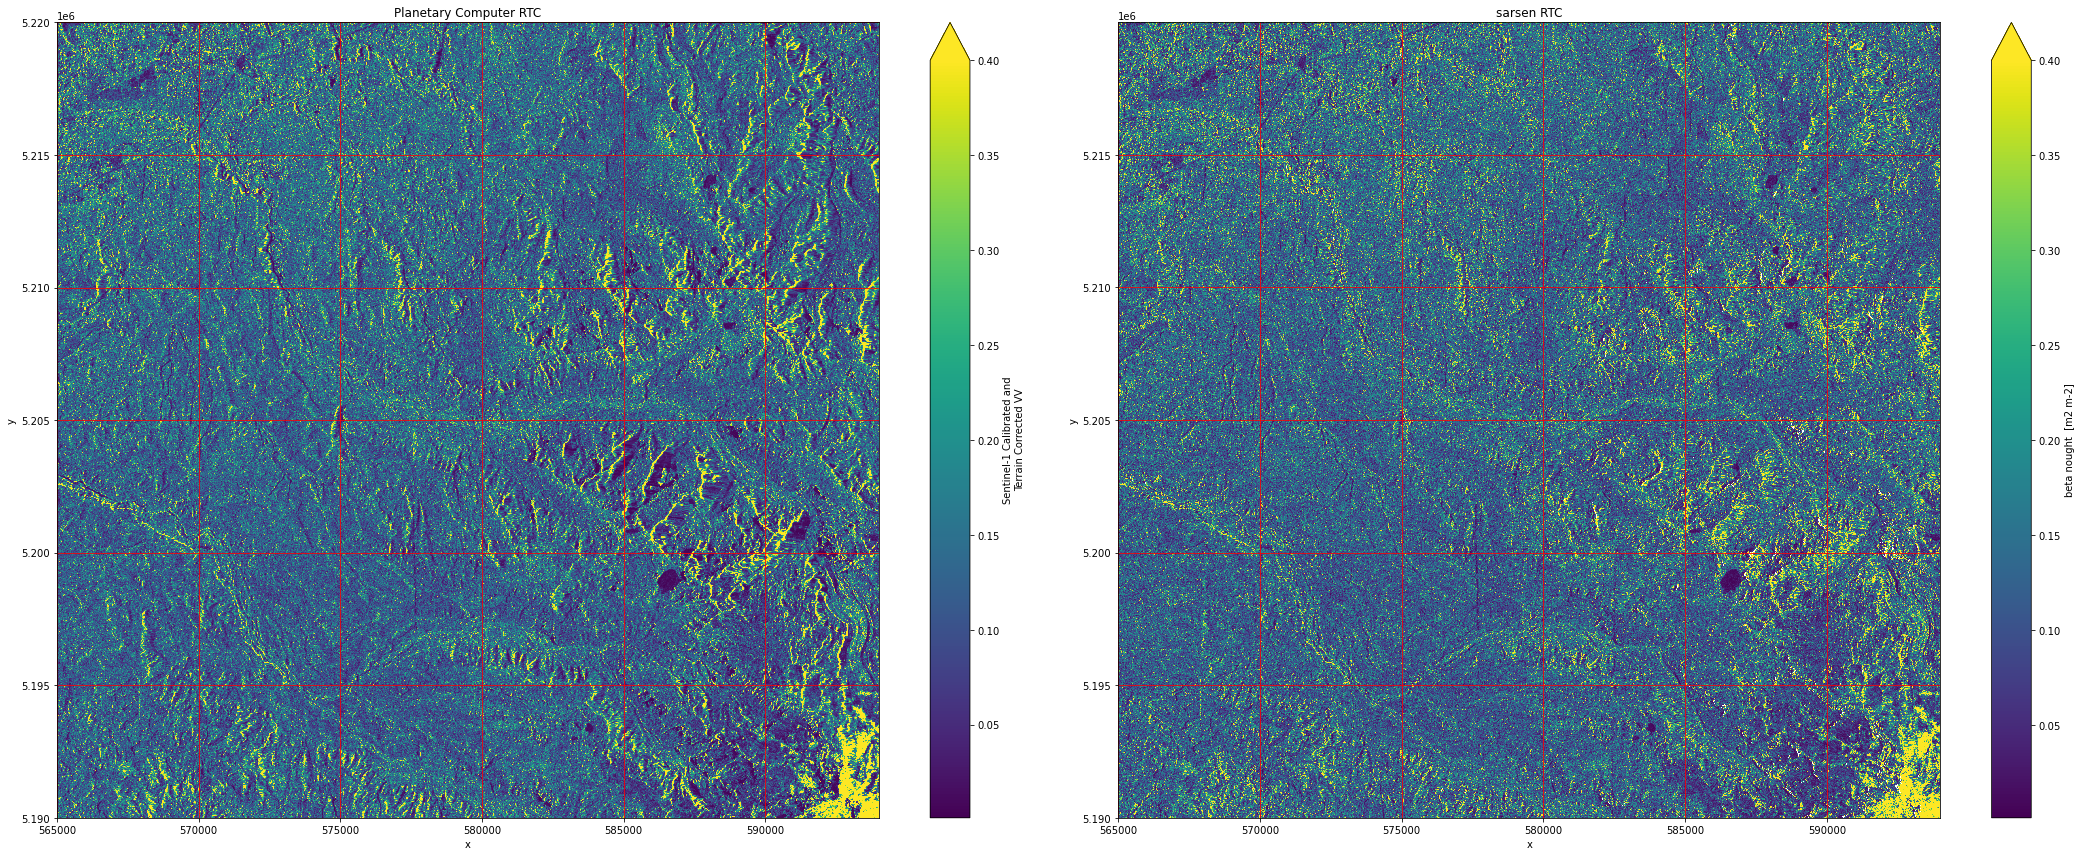

In [20]:
f, axes = plt.subplots(ncols=2, figsize=(30, 12))

rtc_pc.plot(ax=axes[0], vmax=0.4)
axes[0].grid(c="red")
axes[0].set(title="Planetary Computer RTC")

rtc.plot(ax=axes[1], vmax=0.4)
axes[1].grid(c="red")
axes[1].set(title="sarsen RTC")

plt.tight_layout();